In [1]:
print(4)

4


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
import json
import random
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed

In [26]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
    return data

data = readData()

In [27]:

def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    truthOnehot = np.zeros((truth.size, 2))
    truthOnehot[np.arange(truth.size), truth] = 1
    misc = np.array(misc)
    return X, T, truthOnehot, misc



X, T, y, misc = convertData(data)

In [28]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = getTrainTestSplit(X, y)


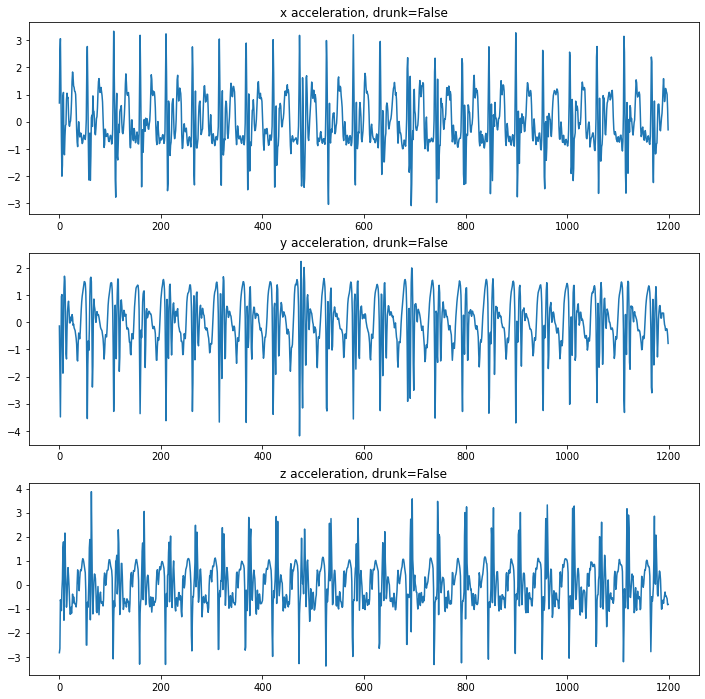

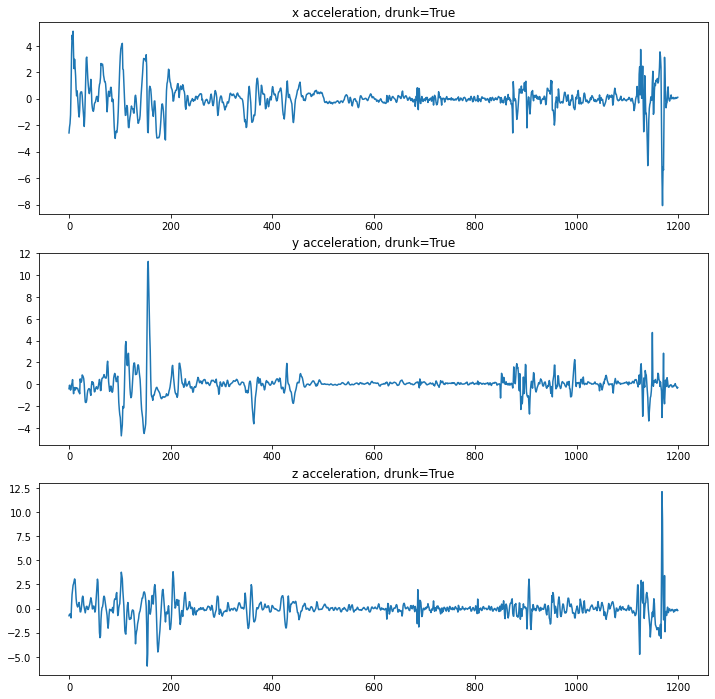

In [29]:
def plot(axes, x, drunk):
    for ax, vals, label in zip(axes, x.T, "xyz"):
        ax.plot([i for i in range(len(vals))], vals)
        ax.set_title(f"{label} acceleration, drunk={drunk}")
    #ax.title = title

def plotdata(X, T, y):
    for option in range(y.shape[1]):
        series = random.choice(X[y.T[option]==1])
        fig, axes = plt.subplots(nrows=3, figsize=(12,12))
        plot(axes, series, option==1)

plotdata(X, T, y)



In [30]:
def trainModel1D(X, y):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=6, batch_size=32)

    return model

In [45]:
def trainModel2D(X, y):
    X = np.expand_dims(X, -1) #new shape = (X.shape[1], X.shape[2], 1)
    print(X.shape)
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(MaxPooling2D(pool_size=(4,4)))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dense(2, activation='softmax'))
    model.fit(X, y, epochs=6, batch_size=32)

    return model

In [56]:
def trainModelAlt(X, y):
    model = Sequential()
    model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(128, input_shape=128))


    model.add(Conv1D(filters=64, kernel_size=3, strides=2, activation='relu', input_shape=(X.shape[1], X.shape[2], X.shape[3])))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    model.fit(X, y, epochs=6, batch_size=32)

    return model

In [57]:
def trainRNN(X, y):
	n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
	model = Sequential()
	model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
	model.add(Dropout(0.5))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	model.fit(X, y, epochs=6, batch_size=32, verbose=False)
	
	return model



In [59]:
def trainLSTM_CNN(X, y):
    cnn = Sequential()
    cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Flatten())
    # define LSTM model
    model = Sequential()
    model.add(TimeDistributed(cnn))
    model.add(LSTM(100, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=6, batch_size=32, verbose=False)

    return model

In [62]:
def trainModels(X, y, repeats=10):
	# repeat experiment
	models = []
	for i in range(repeats):
		print(f"> test {i}")
		model = trainLSTM_CNN(X, y)
		models.append(model)
	return models

def predictTestData(models, X_test):
	predictions = []
	for i, m in enumerate(models):
		y_pred = m.predict(X_test)
		y_pred = y_pred.round()
		predictions.append(y_pred)
	return predictions

def evaluatePredictions(predictions, y):
	scores = []
	for i, y_pred in enumerate(predictions):
		accuracy = metrics.accuracy_score(y, y_pred)
		precision = metrics.precision_score(y, y_pred, average="macro")
		recall = metrics.recall_score(y, y_pred, average="macro")
		
		scores.append([accuracy, precision, recall])
	return scores
# run the experiment
models = trainModels(X_train, y_train)
predictions = predictTestData(models, X_test)
scores = evaluatePredictions(predictions, y_test)

> test 0


ValueError: in user code:

    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Nat\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "time_distributed" (type TimeDistributed).
    
    Input 0 of layer "sequential_45" is incompatible with the layer: expected shape=(None, 1200, 3), found shape=(None, 3)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 1200, 3), dtype=float32)
      • training=True
      • mask=None


In [37]:
def summarize_results(scores):
	s = np.array(scores)
	#m, s = np.mean(scores), np.std(scores)
	chosenMetrics = ["accuracy ", 
					 "precision", 
					 "recall   "]
	mean = s.mean(axis=0)
	std = s.std(axis=0)
	for m, v, d in zip(chosenMetrics, mean, std):
		print(f"{m}: {v :.3f} (+- {d :.3f})")
	#print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

summarize_results(scores)

accuracy : 0.567 (+- 0.005)
precision: 0.383 (+- 0.201)
recall   : 0.503 (+- 0.006)


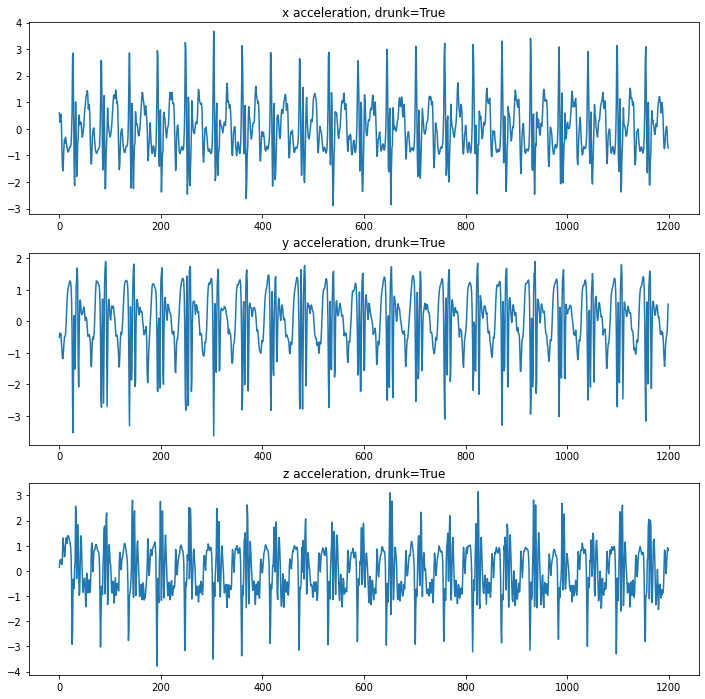

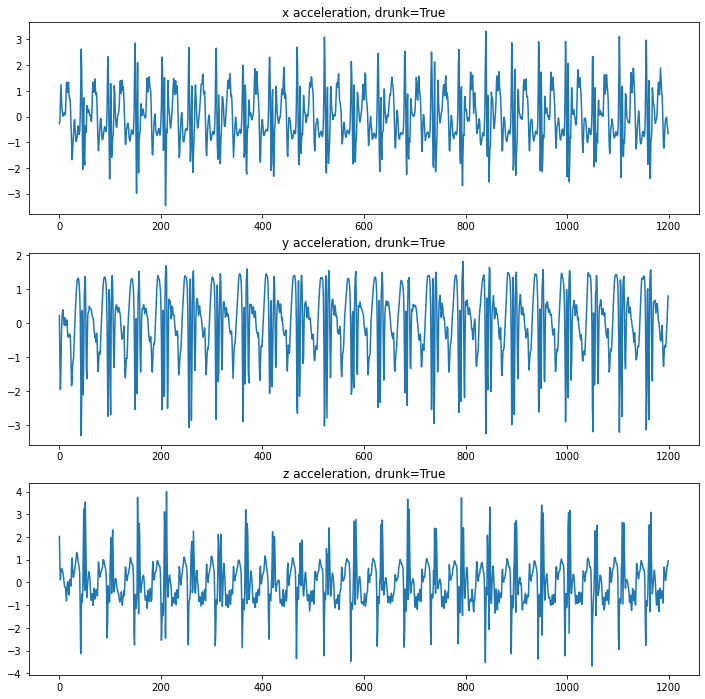

In [20]:
def getFalseNegatives(X, prediction, y):
    grndPositives = y.T[0] == 1
    predNegatives = prediction.T[1] == 1
    falseNegatives = np.logical_and(grndPositives, predNegatives)
    return X[falseNegatives]

falseNegatives = getFalseNegatives(X_test, predictions[0], y_test)


for n in falseNegatives:
    fig, axes = plt.subplots(nrows=3, figsize=(12,12))
    plot(axes, n, True)

26


C:\Users\Nat\AppData\Local\Temp\ipykernel_12092\120968135.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=3, figsize=(12,12))


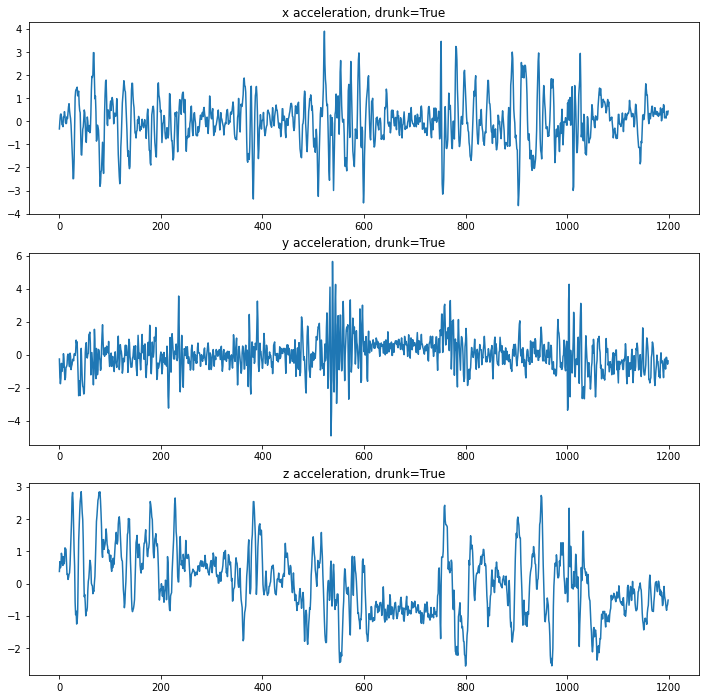

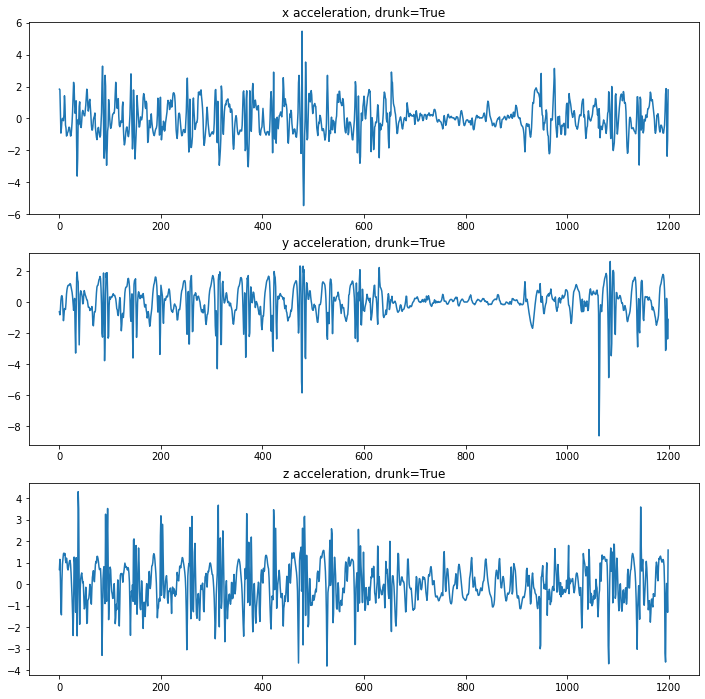

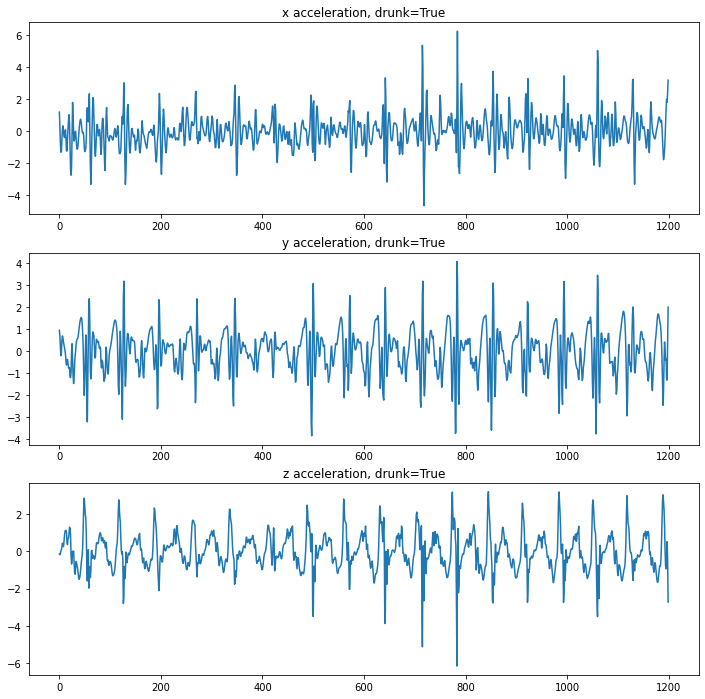

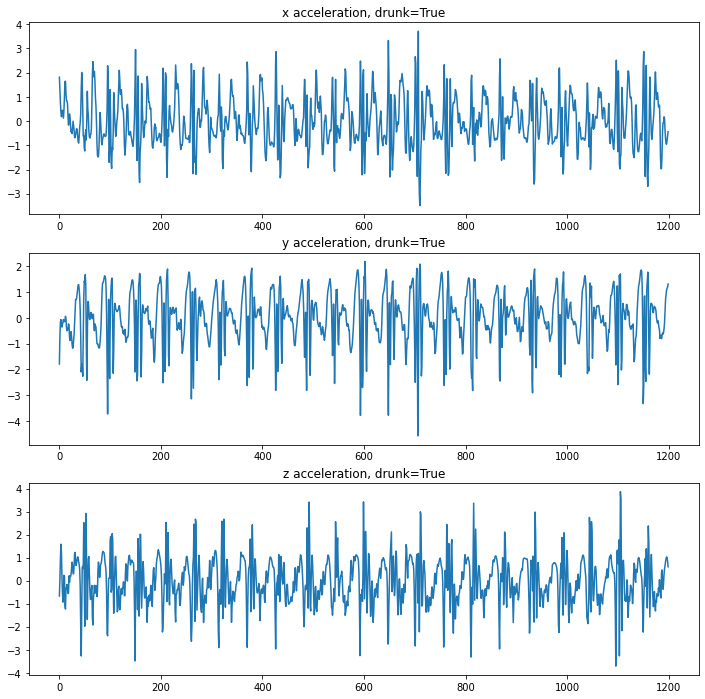

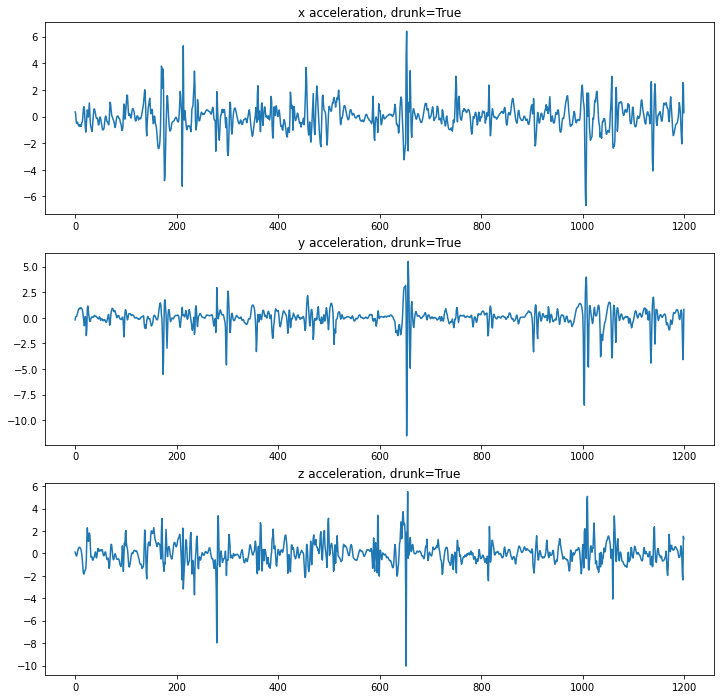

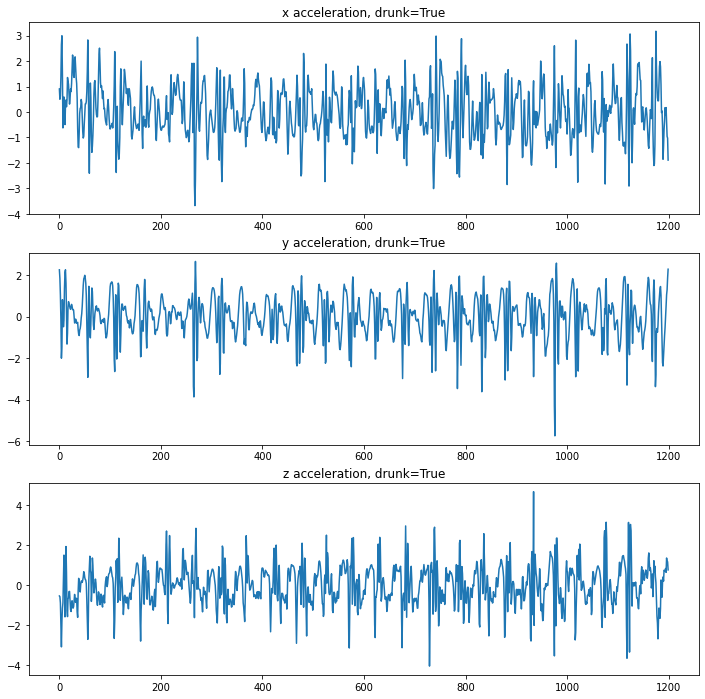

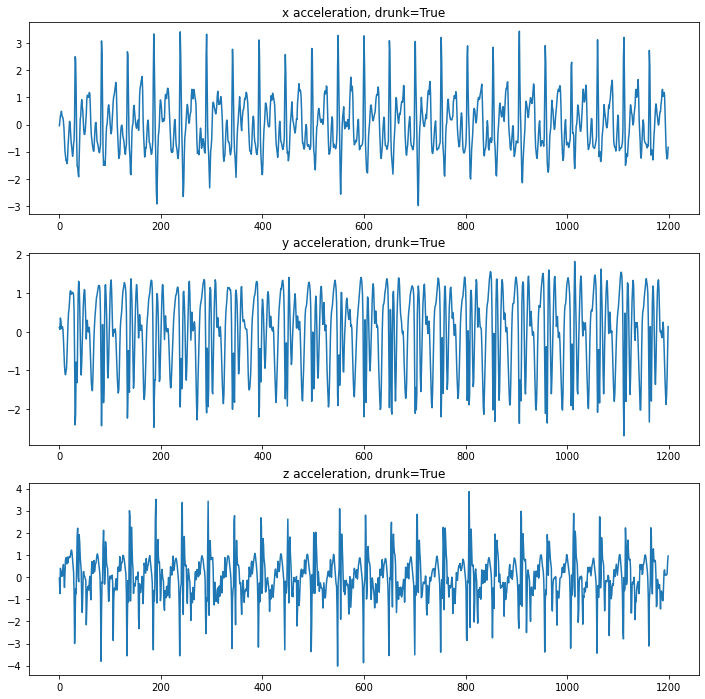

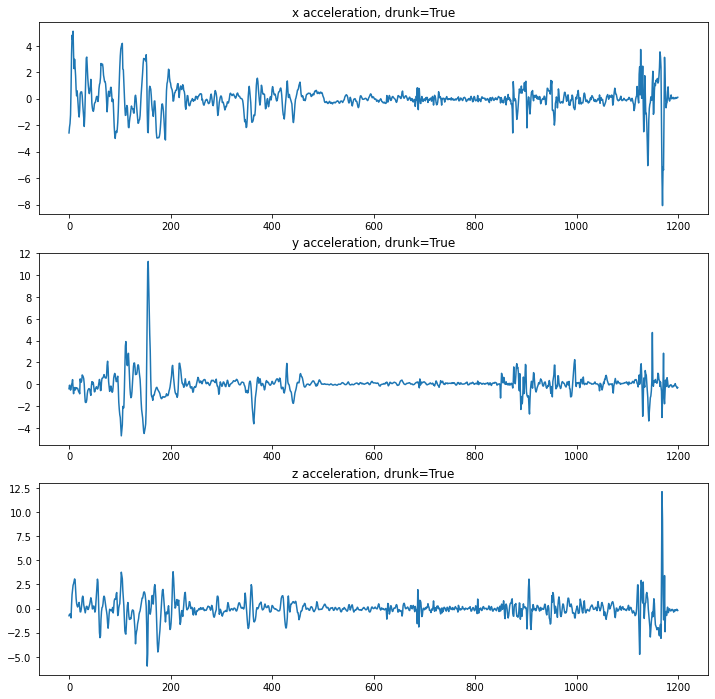

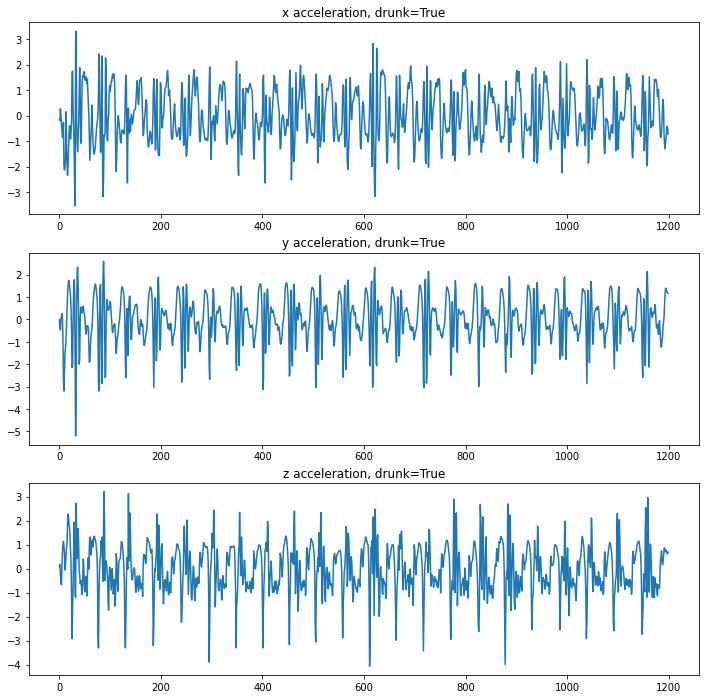

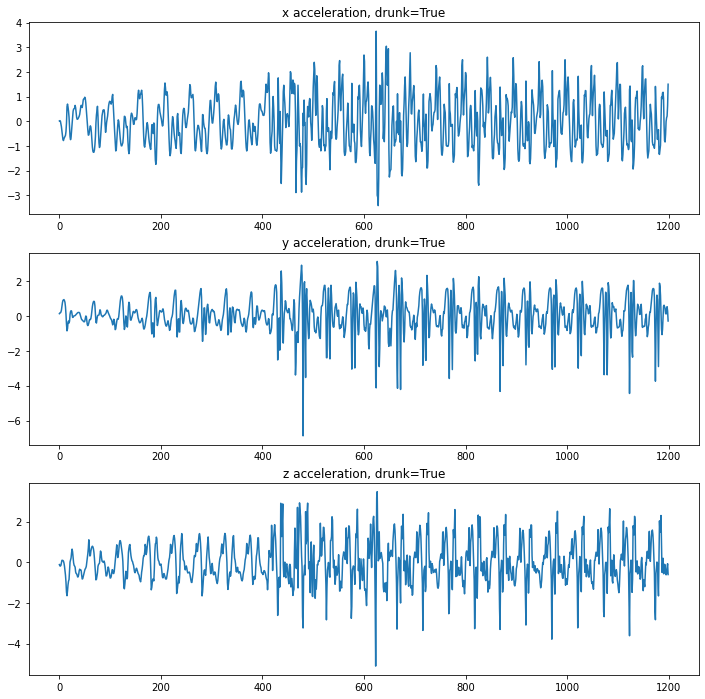

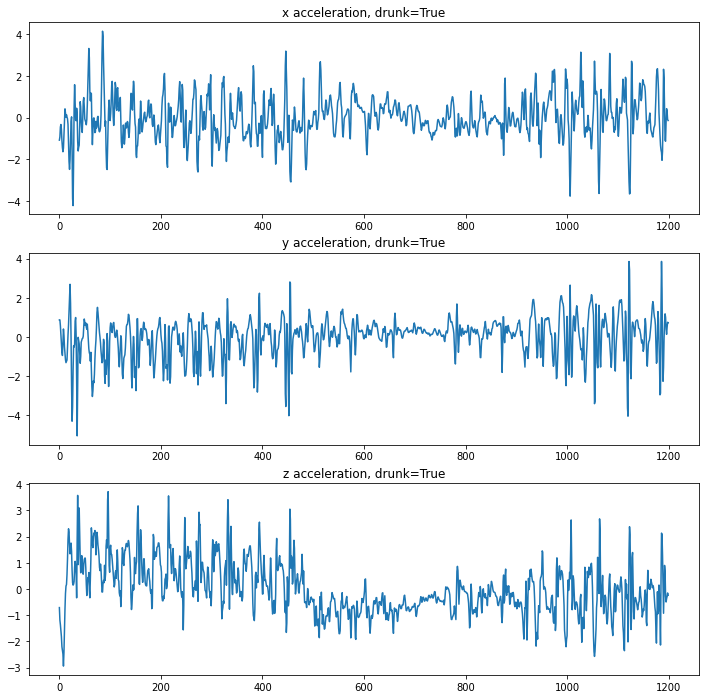

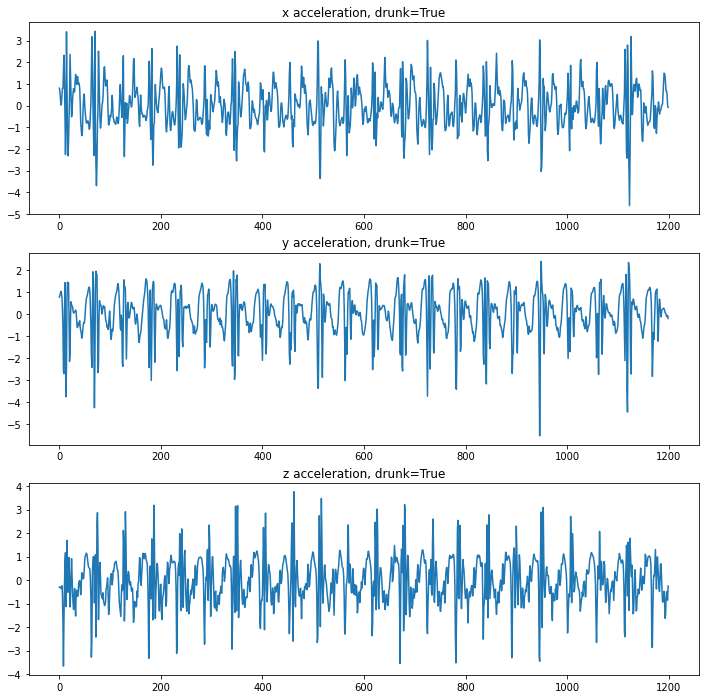

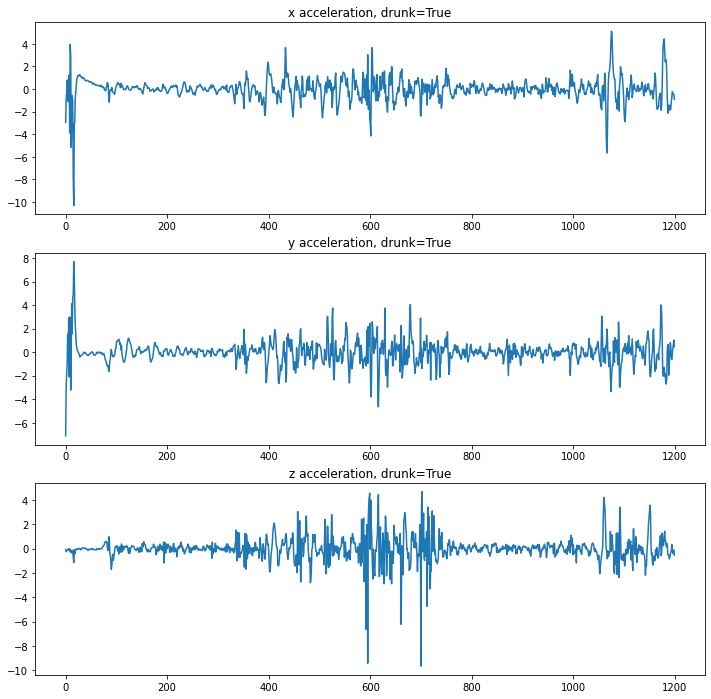

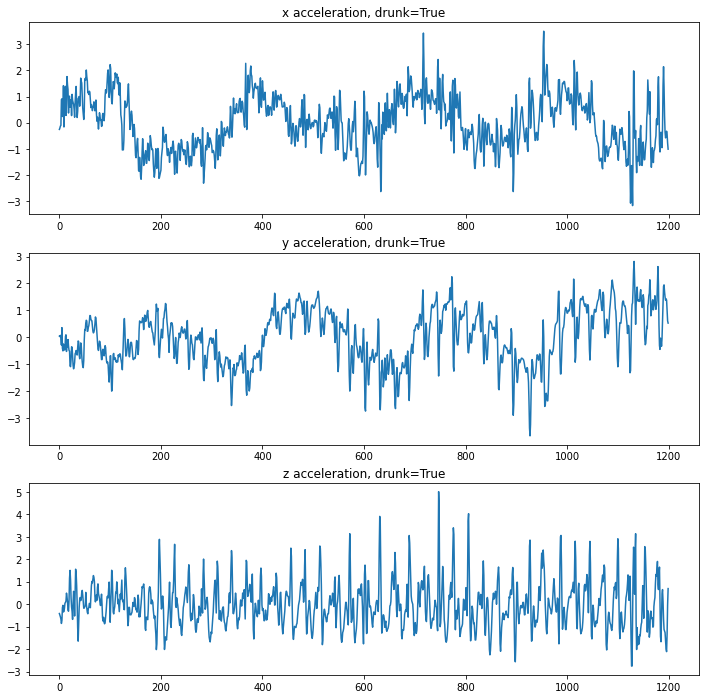

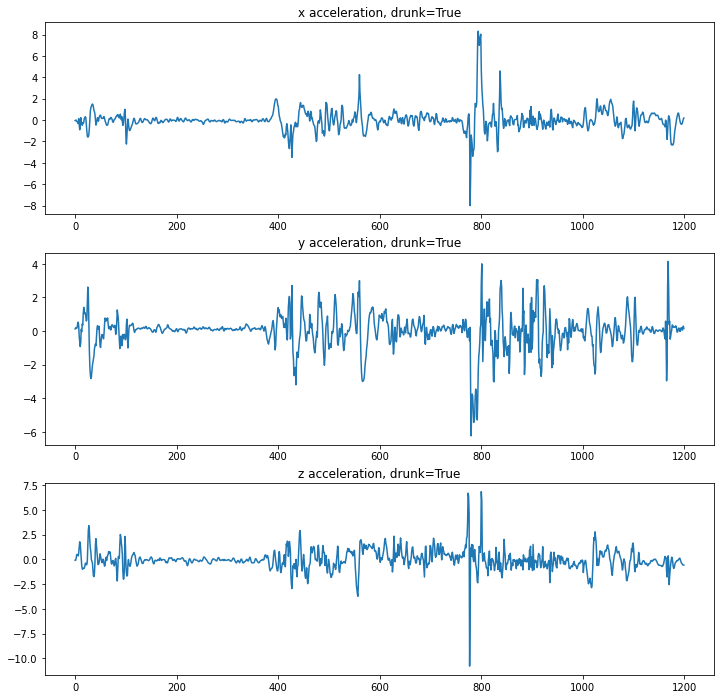

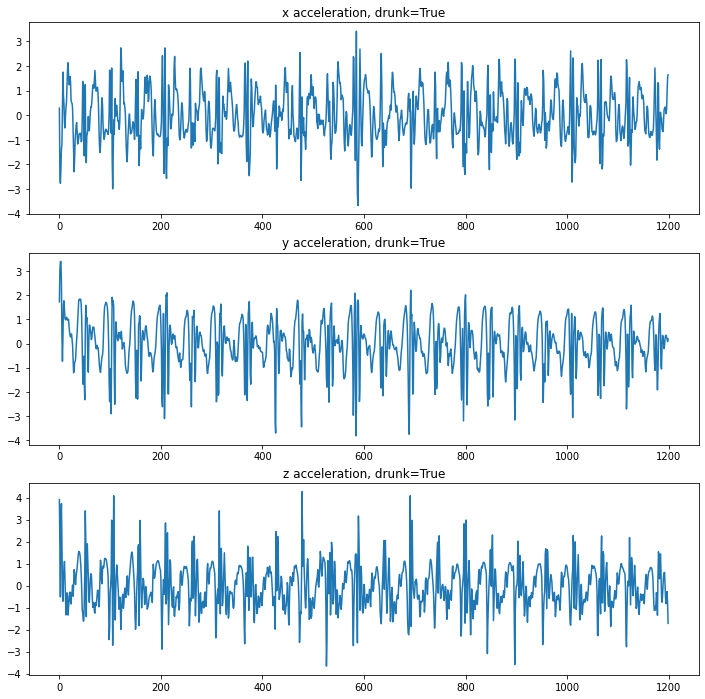

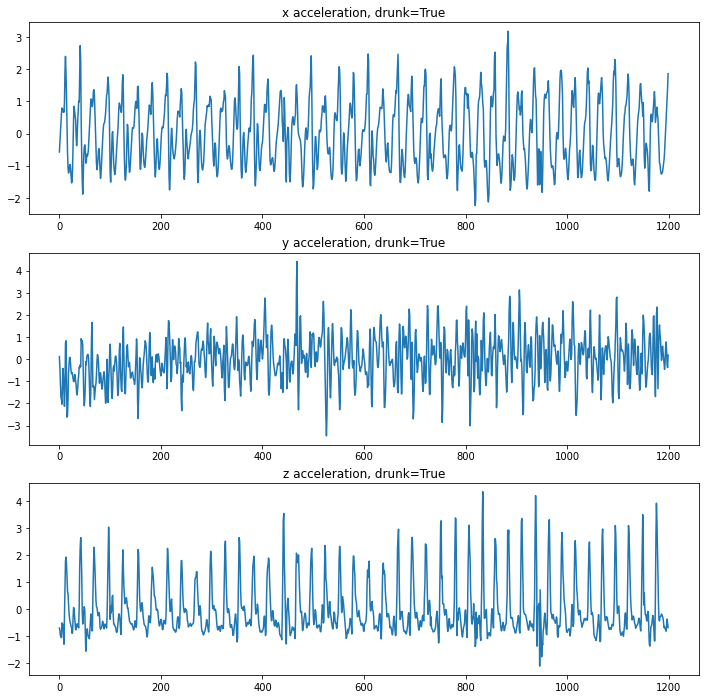

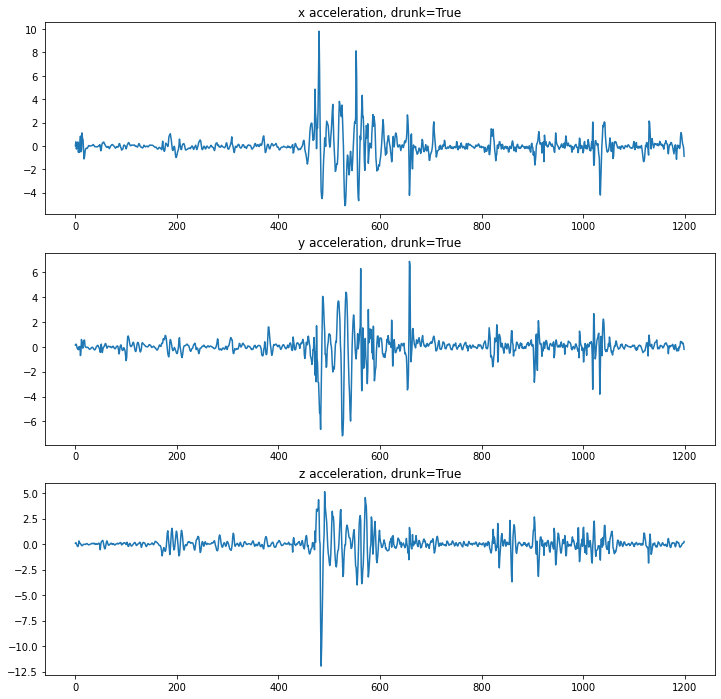

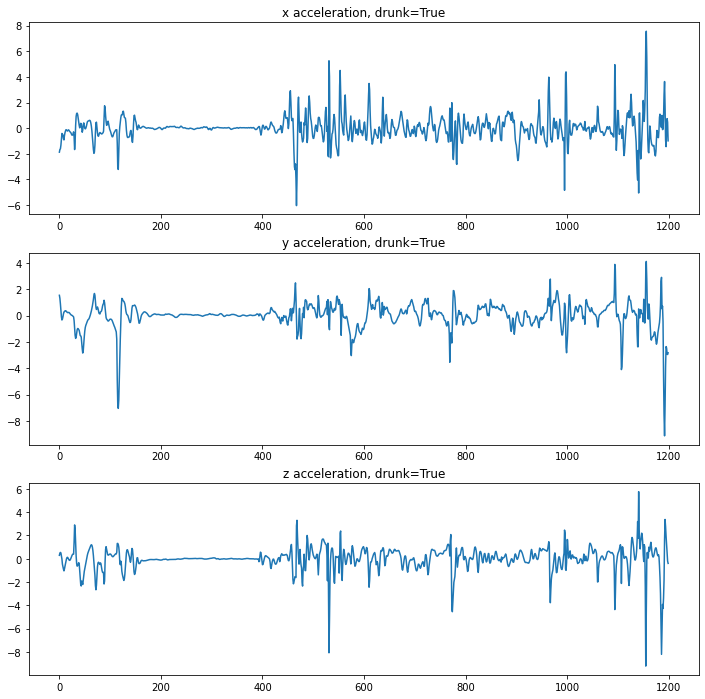

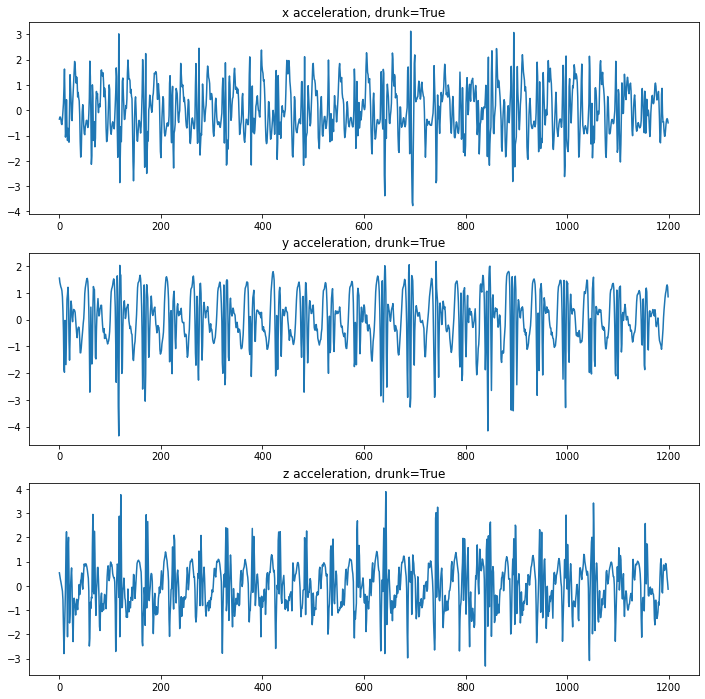

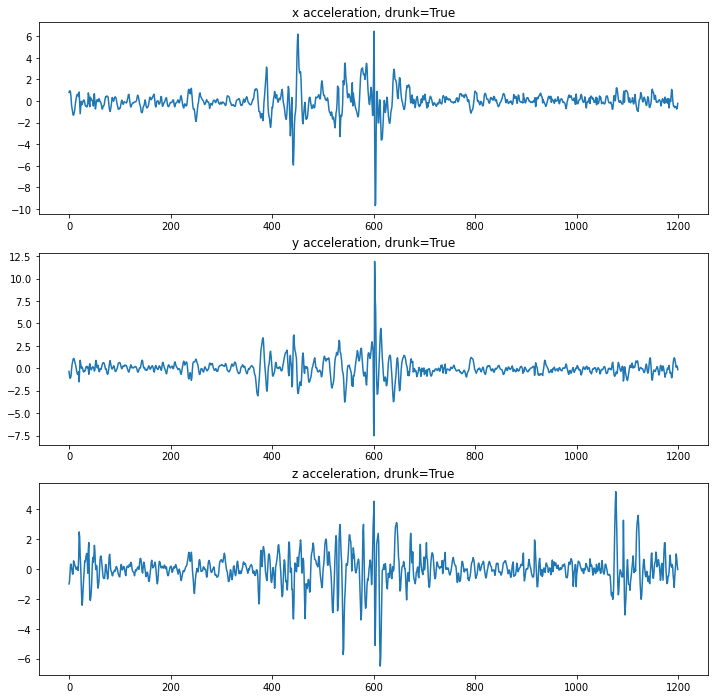

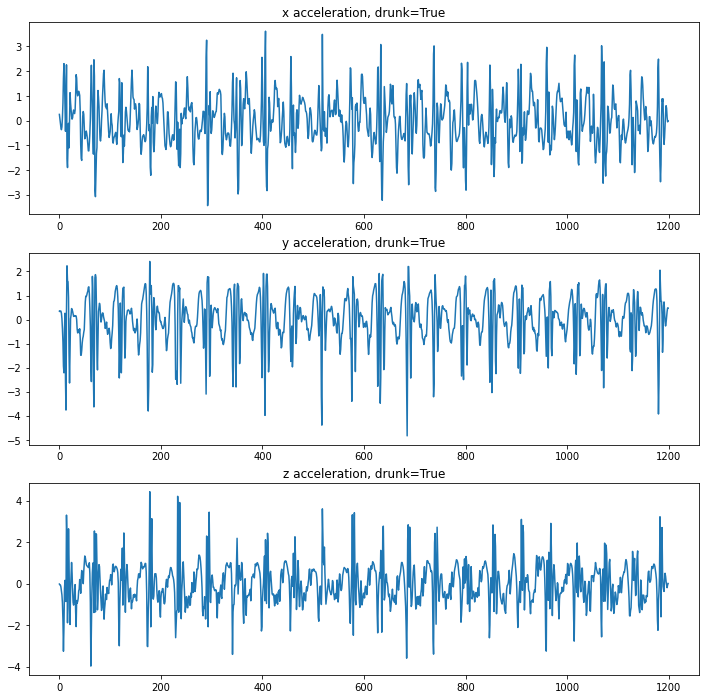

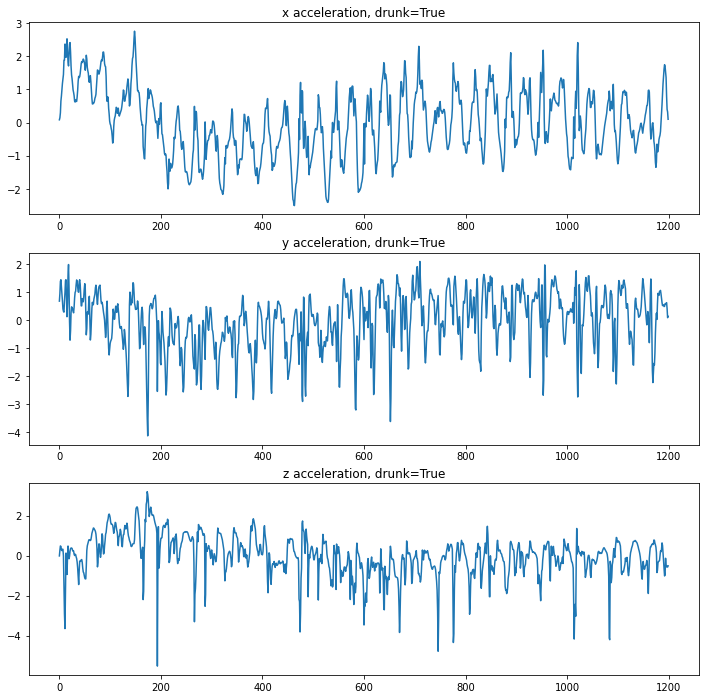

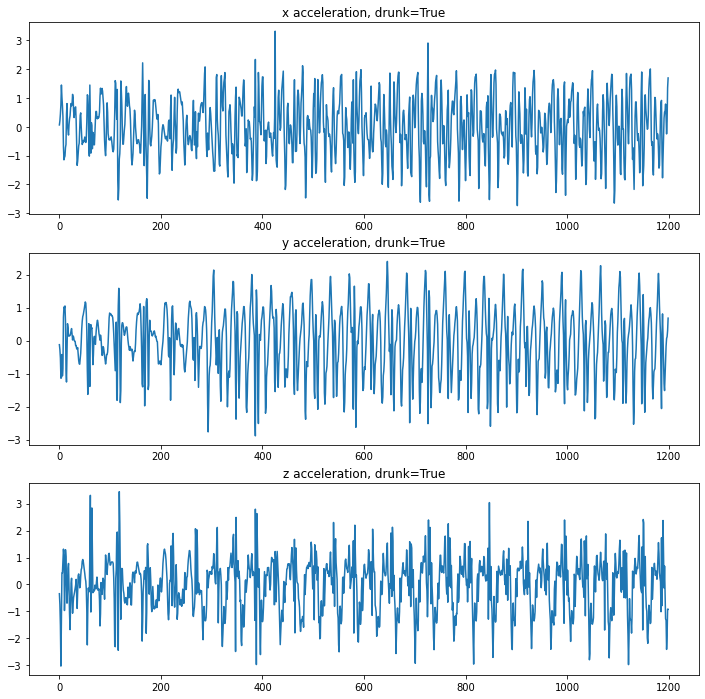

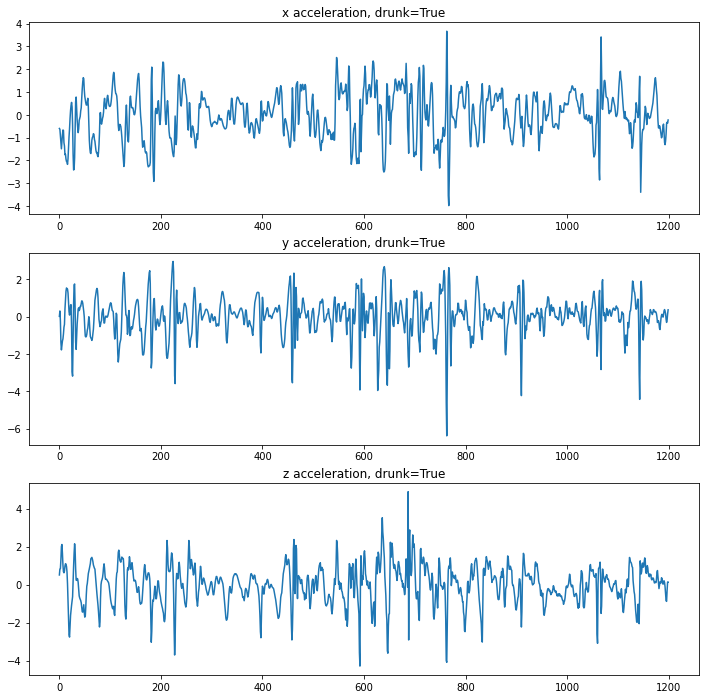

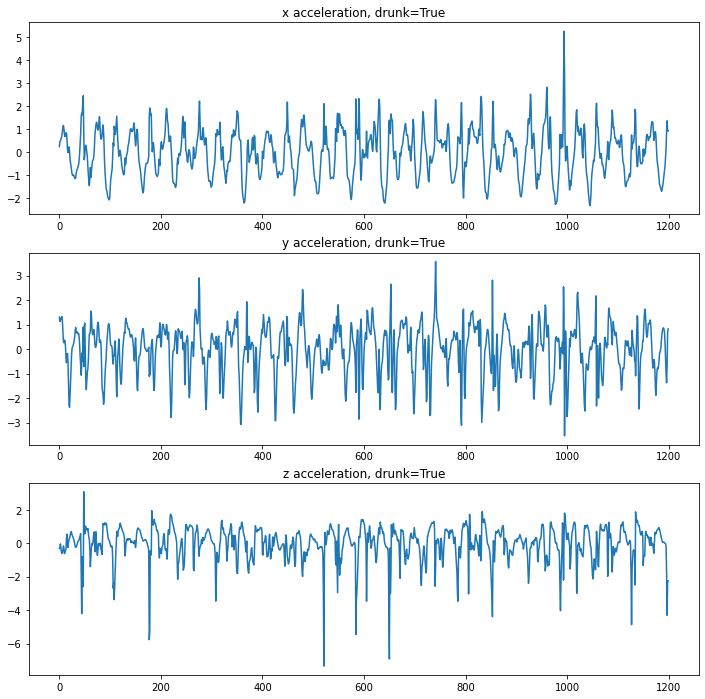

In [21]:
def getFalsePosetives(X, prediction, y):
    grndNegatives = y.T[1] == 1
    predPositives = prediction.T[0] == 1
    falsePosetives = np.logical_and(grndNegatives, predPositives)
    return X[falsePosetives]

falsePosetives = getFalsePosetives(X_test, predictions[0], y_test)
print(len(falsePosetives))

for n in falsePosetives:
    fig, axes = plt.subplots(nrows=3, figsize=(12,12))
    plot(axes, n, True)